Date: 26/10/2021

Version: 3.0 (with documentation)

Environment: Python 3.8.3 and Anaconda 6.0.3

Operating System: macOS Big Sur (Version 11.5.1)

## Table of Contents



* **TASK 1: Data Integration**
    * Helper Functions
    
    * **1.1 Property Data Formatting and Fixation**
        * 1.1.1 XML Property Data
            * 1.1.1.1 XML DF Data Checking/Fixation
        * 1.1.2 JSON Property Data
            * 1.1.2.1 JSON DF Data Checking/Fixation
        * 1.1.3 Concatenating DFs
            * 1.1.3.1 Concatenated DF Checking/Fixation
            
    * **1.2 Using Shapefiles for finding required columns values**
        * 1.2.1 Determining property coordinates lies within which suburb shape boundary
        * 1.2.2 Finding LGAs of the suburbs found
        * 1.2.3 Merging LGAs of Suburb(s)
        
    * **1.3 Using GTFS files to find the required columns**
        * 1.3.1 Checking the GTFS files using gtfs_kit
        * 1.3.2 Reading GTFS files and dynamically creating dataframes for each
        * 1.3.3 Finding closest station and distance to the closest station
        * 1.3.4 Finding travel minutes to Melbourne Central
        * 1.3.5 Creating Direct Journey Flag column
        
    * **1.4 Scraping for Covid Cases**

    * References
    
    

* **TASK 2: Data Reshaping**
    * 1. Original Dataset
    
    * **2. Min-Max Normalization**
        * 2.1 Log Transformation
            * 2.1.1 Log with Min Max [1,2]
        * 2.2 Power Transformation
            * 2.2.1 with Min Max Transformation of Range [0,1]
            * 2.2.2 with Min Max Transformation of Range [1,2]
        * 2.3 Box-Cox Transformation
    
    * **3. Z-Score Normalization (standardization)**
        * 3.1 Power Transformation

    * Conclusion
    
    * References

In [1]:
import pandas as pd
import numpy as np

In [2]:
# setting viewing parameter of the notebook file for better observing/viewing range of data
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)

---
---

# TASK 1: Data Integration

## Helper Functions

In [3]:
# Function to generate report of fixation of dataframe

# This has been written because these steps have to carried out quite 
# several times to achieve the tasks in our hand. So to prevent redundant
# code writing we make use of the helper functions.

def generate_df_fix_report(df):
    """
     function to generate log report of carried fixation tasks of dataframe
     :param
        df : dataframe name on which the tasks are to be performed
    """
    
    print()
    print('*'*20)
    print('Dataframe Shape:', df.shape)
    
    print()
    print('*'*20)
    print('Duplicated Rows considering all columns:')
    
    duplicate_rows_all_cols = df[df.duplicated(keep=False)].sort_values(by=['property_id'])
    display(duplicate_rows_all_cols)
    
    if(duplicate_rows_all_cols.shape[0] > 0):
        print('FIXING DUPLICATES BY ALL COLUMNS!!')
        df.drop_duplicates(keep='first', inplace=True)
    
    print()
    print('*'*20)
    
    print('Duplicated Rows considering only property_id column:')

    duplicate_rows_prop_col = df[df.duplicated('property_id', keep=False)].sort_values(by=['property_id'])
    display(duplicate_rows_prop_col)
    
    
    if(duplicate_rows_prop_col.shape[0] > 0 ):
        print('FIXING DUPLICATES BY property_id COLUMN!!')
        df.drop_duplicates(subset=['property_id'], keep='first', inplace=True)
    else:
        print('There is no duplicates present and property_id contains only unique')
        
    print()
    print('*'*20)
        
    print('Another possible scenario can be to check duplicate in [lat, lng] as a whole because same property cannot have exact same coordinats')
    
    
    duplicate_rows_latlng_cols = df[df.duplicated(['lat', 'lng'], keep=False)].sort_values(by=['lat'])
    display(duplicate_rows_latlng_cols)
    
    if(duplicate_rows_latlng_cols.shape[0] > 0):
        print('FIXING DUPLICATES BY "[lat, lng]" COLUMN!!')
        df.drop_duplicates(subset=['lat','lng'], keep='first', inplace=True)
    else:
        print('There is no duplicates present by "[lat, lng]"')
    

# 1. 1 Property Data Formatting and Fixation

## 1.1.1 XML Property Data
\
***Methodology***:

Here we are given properties data as a form of XML and our task is to successfully parse and convert it to dataframe for usage in furthur tasks. Initially we fix our XML as it is unparsable when tried to parse with `xml.etree.ElementTree`. After successful parse we convert the xml to dataframe and look for possible problems(if any) in our dataset.

\
**xml.etree.ElementTree** : simple and efficient package for parsing and creating XML data.

In [4]:
# importing required packages for xml parsing and reading

import xml.etree.ElementTree as ET
import re


Let's us use the `parse()` function for our xml file.

In [5]:
try:
    tree = ET.parse('31072100.xml')
except Exception as e:
    print('ERROR!!!:', e)

ERROR!!!: junk after document element: line 7, column 0


> Our initial parse try failed and giving us error on line 7, let us debug it

In [6]:
# reading the file in r+ (read+write) mode

with open('31072100.xml','r') as xml_file:
    content = xml_file.read() 
    
    print('Printing intitial few content for debugging:')
    print()
    print(content[:301])    # content check
    
#     xml_file.seek(0,0)
    
#     # writing to xml file. with appended new tag
#     xml_file.write('<property_details>' + '\n' + content + '\n' + '</property_details>')

# #     xml_file.seek(0,0)

Printing intitial few content for debugging:

<property>
  <property_id>30536</property_id>
  <lat>-37.775353</lat>
  <lng>145.003039</lng>
  <addr_street>9a Andrew Street</addr_street>
</property>
<property>
  <property_id>83256</property_id>
  <lat>-37.888303</lat>
  <lng>145.243893</lng>
  <addr_street>6 Towner Drive</addr_street>
</property>


In [7]:
fixed_xml = open("31072100.xml", "w")
fixed_xml.write('<property_details>' + '\n' + content + '\n' + '</property_details>')
fixed_xml.close()

In the above step we noticed and observed the outermost xml tag is missing in our xml file. By making the use of `seek()` we position the cursor to append the `<property_details>` new tag to the actual content.

Let's us again try `parse()` function for our xml file.

In [8]:
try:
    tree = ET.parse('31072100.xml')
except Exception as e:
    print('ERROR!!!:', e)

ERROR!!!: not well-formed (invalid token): line 1092, column 18


> We still have some issues with the XML structure/file. As this is an `(invalid token)` error and by recalling that xml has some few reserved tokens. For example: &, ', ", etc.

> Let us explore these tokens and fix them if available

In [9]:
# reading file in 'r' mode and using regex to find instances of '&'
# if present

with open('31072100.xml','r') as xml_file:
    content = xml_file.read()
        
    for sp_char in ['&']:
        
        sp_matches = re.findall(r"(?:\{})".format(sp_char), content)
        print(sp_matches)
        
        if len(sp_matches) > 0:
            print('No of such casese: ', len(sp_matches))
            
            # replacing '&' with '&amp;' and storing in variable
            content = re.sub(r"(?:\{})".format(sp_char), '&amp;', content)
            

['&', '&', '&']
No of such casese:  3


In [10]:
# writing the variable we collected above to the file with 'w' mode

fixed_xml = open("31072100.xml", "w")
fixed_xml.write(content)
fixed_xml.close()

Let's us again try `parse()` function for our fixed XML file. Hopefully third time's the charm.

In [11]:
try:
    xtree = ET.parse('31072100.xml')
    print('Parsed Successfully !!!')
except Exception as e:
    print('ERROR!!!:', e)

Parsed Successfully !!!


> We have successfully parsed the XML file. Time to move on to next lined up tasks

In [12]:
# selecting root to start with
xroot = xtree.getroot()
xroot

<Element 'property_details' at 0x7ffb8f691a90>

Converting XML data to dataframe.

In [13]:
rows = []

# for each node in xroot keep appending the required tags as data rows
for node in xroot:
    
    rows.append({
        "property_id": node.find('property_id').text,
        "lat": node.find('lat').text, 
        "lng": node.find('lng').text, 
        "addr_street": node.find('addr_street').text
    })
    
# converting to dataframe    
prop_xml_df = pd.DataFrame(rows)
print(prop_xml_df.shape) # shape of dataset

# printing glimpses of dataset
display(prop_xml_df.head())
display(prop_xml_df.tail())

(1212, 4)


,property_id,lat,lng,addr_street
0,30536,-37.775353,145.003039,9a Andrew Street
1,83256,-37.888303,145.243893,6 Towner Drive
2,64418,-37.804006,145.29741299999995,4 Edward Court
3,96343,-37.915334,145.048999,9a Osborne Avenue
4,46118,-37.709881,145.12116,48 Sherbourne Road


,property_id,lat,lng,addr_street
1207,62050,-37.794843,145.25203100000004,5 Highland Blvd
1208,88808,-37.95315,145.055631,34 Mount View Road
1209,24565,-37.716997,144.972064,7 Wilson Street
1210,68944,-37.85042953,145.03591919999997,23 Elizabeth Street
1211,415,-37.800241,144.888949,168 Geelong Road


### 1.1.1.1 XML DF Data Checking/Fixation 

By usin the helper function `generate_df_fix_report()` we generate the fixation report showing logs of all the steps we have taken.

In [14]:
generate_df_fix_report(prop_xml_df)


********************
Dataframe Shape: (1212, 4)

********************
Duplicated Rows considering all columns:


,property_id,lat,lng,addr_street
208,1791,-37.78439331,144.8821716,14 Cathcart Street
613,1791,-37.78439331,144.8821716,14 Cathcart Street
423,1914,-37.805783,144.882514,19 Empress Avenue
770,1914,-37.805783,144.882514,19 Empress Avenue
213,23217,-37.735683,144.97854099999995,85 Murray Road
963,23217,-37.735683,144.97854099999995,85 Murray Road
1083,30812,-37.756014,144.987245,160 Smith Street
1066,30812,-37.756014,144.987245,160 Smith Street
1043,32590,-37.733573,144.987318,31 Benambra Street
853,32590,-37.733573,144.987318,31 Benambra Street


FIXING DUPLICATES BY ALL COLUMNS!!

********************
Duplicated Rows considering only property_id column:


,property_id,lat,lng,addr_street


There is no duplicates present and property_id contains only unique

********************
Another possible scenario can be to check duplicate in [lat, lng] as a whole because same property cannot have exact same coordinats


,property_id,lat,lng,addr_street


There is no duplicates present by "[lat, lng]"


In [15]:
prop_xml_df.shape

(1199, 4)

In [16]:
prop_xml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199 entries, 0 to 1211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  1199 non-null   object
 1   lat          1199 non-null   object
 2   lng          1199 non-null   object
 3   addr_street  1199 non-null   object
dtypes: object(4)
memory usage: 46.8+ KB


## 1.1.2 JSON Property Data
\
***Methodology***:

Here we are given properties data as a form of JSON and our task is to successfully parse and convert it to a dataframe for usage in furthur tasks. We convert the JSON to dataframe using pandas' `read_json()` and and look for possible problems(if any) to fix.

\
**read_json()**: Convert a JSON string to pandas object.

In [17]:
prop_json_df = pd.read_json('31072100.json', dtype='object')
print(prop_json_df.shape)

# glimpse after converting to dataframe
display(prop_json_df.head())
display(prop_json_df.tail())

(1216, 4)


,property_id,lat,lng,addr_street
0,62050,-37.794843,145.252031,5 Highland Blvd
1,88808,-37.95315,145.055631,34 Mount View Road
2,24565,-37.716997,144.972064,7 Wilson Street
3,68944,-37.85043,145.035919,23 Elizabeth Street
4,415,-37.800241,144.888949,168 Geelong Road


,property_id,lat,lng,addr_street
1211,47682,-37.801933,145.037933,1 New Street
1212,74052,-37.861809,145.264874,9 / 23 Dixon Court
1213,32089,-37.739868,145.013051,18 Mutimer Street
1214,57499,-37.822559,145.149349,1/37 The Avenue
1215,46839,-37.730952,145.138151,20 Porter Street


In [18]:
prop_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  1216 non-null   object
 1   lat          1216 non-null   object
 2   lng          1216 non-null   object
 3   addr_street  1216 non-null   object
dtypes: object(4)
memory usage: 38.1+ KB


In [19]:
# prop_json_df.iloc[8]['lng']

### 1.1.2.1 JSON DF Data Checking/Fixation 

By usin the helper function `generate_df_fix_report()` we generate the fixation report showing logs of all the steps we have taken.

In [20]:
generate_df_fix_report(prop_json_df)


********************
Dataframe Shape: (1216, 4)

********************
Duplicated Rows considering all columns:


,property_id,lat,lng,addr_street
986,22093,-37.754142,144.959629,17 Jessie Street
1179,22093,-37.754142,144.959629,17 Jessie Street
562,28814,-37.803051,144.995105,136 Park Street
930,28814,-37.803051,144.995105,136 Park Street
428,29797,-37.767818,144.985138,25 Zoe Circuit
856,29797,-37.767818,144.985138,25 Zoe Circuit
768,41113,-37.713953,145.036512,73 Dunne Street
875,41113,-37.713953,145.036512,73 Dunne Street


FIXING DUPLICATES BY ALL COLUMNS!!

********************
Duplicated Rows considering only property_id column:


,property_id,lat,lng,addr_street


There is no duplicates present and property_id contains only unique

********************
Another possible scenario can be to check duplicate in [lat, lng] as a whole because same property cannot have exact same coordinats


,property_id,lat,lng,addr_street


There is no duplicates present by "[lat, lng]"


In [21]:
prop_json_df.shape

(1212, 4)

In [22]:
prop_json_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1212 entries, 0 to 1215
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  1212 non-null   object
 1   lat          1212 non-null   object
 2   lng          1212 non-null   object
 3   addr_street  1212 non-null   object
dtypes: object(4)
memory usage: 47.3+ KB


# 1.1.3 Concatenating DFs

In [23]:
print(prop_xml_df.shape)
print(prop_json_df.shape)

(1199, 4)
(1212, 4)


In [24]:
print(prop_xml_df.columns)
print(prop_json_df.columns)

Index(['property_id', 'lat', 'lng', 'addr_street'], dtype='object')
Index(['property_id', 'lat', 'lng', 'addr_street'], dtype='object')


In [25]:
# concatenating prop_xml_df and prop_json_df
property_df = pd.concat([prop_xml_df, prop_json_df], ignore_index=True)

property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   property_id  2411 non-null   object
 1   lat          2411 non-null   object
 2   lng          2411 non-null   object
 3   addr_street  2411 non-null   object
dtypes: object(4)
memory usage: 75.5+ KB


In [26]:
property_df.shape

(2411, 4)

In [27]:
# converting data types of required columns
property_df['property_id'] = property_df['property_id'].astype('int64')
property_df['lat'] = property_df['lat'].astype('float64')
property_df['lng'] = property_df['lng'].astype('float64')

property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  2411 non-null   int64  
 1   lat          2411 non-null   float64
 2   lng          2411 non-null   float64
 3   addr_street  2411 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 75.5+ KB


\
Changing precision of both `lat` and `lng` columns to 6 as both dataframes have mismatch precision, so this is necessay if want to compare

In [28]:
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  2411 non-null   int64  
 1   lat          2411 non-null   float64
 2   lng          2411 non-null   float64
 3   addr_street  2411 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 75.5+ KB


## 1.1.3.1 Concatenated DF Checking/Fixation
\
We first check if latitude and longitude falls in the ranges and fix(if any). Then, we make use of the `generate_df_fix_report()` helper functions to fix other problems of duplications. 

In [29]:
property_df.shape

(2411, 4)

Each line of **longitude** runs north and south and measures the number of degrees east or west of the Prime Meridian. Values range from **positive 180 to negative 180 degrees.**

Lines of **latitude** run from east to west and measure the number of degrees north or south of the Equator. Values range from the North Pole, at **positive 90 degrees**, to the South Pole which is located at **negative 90 degrees.**

[Source](https://www.fws.gov/stand/standards/de_latlon_WWW.html)

As longitude can be from `-180 to 180`, performing a check on it may not generate out of range results. A better approach will be to check the latitude values outside the range of `-90 t0 90` (if any)

In [30]:
# lat of property_df out of range error check

property_df[
    ~(
        (property_df['lat'] >= -90) & 
        (property_df['lat'] <= 90) 
    )]

,property_id,lat,lng,addr_street


> All good with coordinates

In [31]:
generate_df_fix_report(property_df)


********************
Dataframe Shape: (2411, 4)

********************
Duplicated Rows considering all columns:


,property_id,lat,lng,addr_street
1198,415,-37.800241,144.888949,168 Geelong Road
1203,415,-37.800241,144.888949,168 Geelong Road
952,1015,-37.800980,144.890214,42 Buckingham Street
2312,1015,-37.800980,144.890214,42 Buckingham Street
1201,24565,-37.716997,144.972064,7 Wilson Street
1196,24565,-37.716997,144.972064,7 Wilson Street
247,30172,-37.776091,144.989510,5 St Georges Road
1568,30172,-37.776091,144.989510,5 St Georges Road
2380,72762,-37.849579,145.286778,1/354 Dorset Road
982,72762,-37.849579,145.286778,1/354 Dorset Road


FIXING DUPLICATES BY ALL COLUMNS!!

********************
Duplicated Rows considering only property_id column:


,property_id,lat,lng,addr_street
2353,6200,-37.780403,144.842541,146 Cornwall Road
562,6200,-37.780403,144.842541,146 Cornwall Road
334,19358,-37.660653,144.934566,20 Crossley Crescent
2011,19358,-37.660653,144.934566,20 Crossley Crescent
2161,19442,-37.661411,144.926956,41 Longford Crescent
283,19442,-37.661411,144.926956,41 Longford Crescent
1125,44634,-37.717117,145.103921,212 Elder Street
1585,44634,-37.717117,145.103921,212 Elder Street
1194,62050,-37.794843,145.252031,5 Highland Blvd
1199,62050,-37.794843,145.252031,5 Highland Blvd


FIXING DUPLICATES BY property_id COLUMN!!

********************
Another possible scenario can be to check duplicate in [lat, lng] as a whole because same property cannot have exact same coordinats


,property_id,lat,lng,addr_street


There is no duplicates present by "[lat, lng]"


In [32]:
property_df.shape

(2392, 4)

# 1.2 Using Shapefiles for finding required columns values
\
Information of few types of files included. `.shp` files requires other related files to be present for successful usage and read.

> `.shp:` the file that contains the geometry for all features.

> `.shx:` the file that indexes the geometry.

> `.dbf:` the file that stores feature attributes in a tabular format.

> `.prj:` the file that contains information on projection format including the coordinate system and projection information. It is a plain text file describing the projection using well-known text (WKT) format.

In [33]:
# pip installing the required pacakge(s)

!pip install geopandas

In [34]:
# importing required pacakges

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import geometry

In [35]:
# reading the shape file (.shp) using geopandas read_file()
suburb_boundary_shp = gpd.read_file('supplementary_data/vic_suburb_bounadry/VIC_LOCALITY_POLYGON_shp.shp')

In [36]:
print(suburb_boundary_shp.shape)
display(suburb_boundary_shp.head())

(2973, 13)


,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552 -35.07229, 141.74552 -35.0..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.66877 -37.39571, 148.66876 -37.3..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92288 -37.97886, 142.90449 -37.9..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82336 -37.66001, 147.82313 -37.6..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.27978 -35.99859, 141.27989 -35.9..."


> There are quite a few columns present in the dataframe. For our task our focus will be on `VIC_LOCA_2` and `geometry` columns

Building the shapefile using matplotlib to get a sense of region/area we have this also checks if the map is actually of Victoria or not.

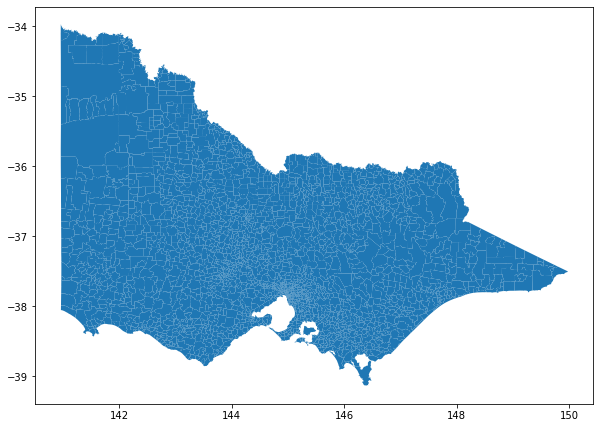

In [37]:
fig, ax = plt.subplots(figsize = (10,10))
suburb_boundary_shp.plot(ax=ax)
plt.show()

> This is perfect map of Victoria with boundaries of suburbs.

In [38]:
# suburb_boundary_shp['geometry_list'] = suburb_boundary_shp['geometry'].apply(lambda x: list(x.exterior.coords))
# suburb_boundary_shp.head(3)

In [39]:
# suburb_boundary_shp[['geometry', 'geometry_list']].iloc[5][0]

## 1.2.1 Determining property coordinates lies within which suburb shape boundary

Now with the polygon shape o surburb in hand and coordinates available of properties, our task is to find the suburbs of properties. The methodology is exaplained as the tasks proceed here.

In [40]:
print(property_df.shape)
property_df.head(3)

(2392, 4)


,property_id,lat,lng,addr_street
0,30536,-37.775353,145.003039,9a Andrew Street
1,83256,-37.888303,145.243893,6 Towner Drive
2,64418,-37.804006,145.297413,4 Edward Court


In [41]:
# property_df.iloc[0]

**GeoDataFrame**

A GeoDataFrame object is a pandas.DataFrame that has a column with geometry. We pass `lng` and `lat` to convert them to geometry POINT object. Another arguments we pass is:

* **crs:** Coordinate Reference System of the geometry objects. In our case it is `4283` for shapefile so we use the same here.

In [42]:
property_geodf = gpd.GeoDataFrame(property_df, geometry=gpd.points_from_xy(property_df['lng'], property_df['lat'], crs=4283))
property_geodf.columns

Index(['property_id', 'lat', 'lng', 'addr_street', 'geometry'], dtype='object')

In [43]:
property_geodf.head()

,property_id,lat,lng,addr_street,geometry
0,30536,-37.775353,145.003039,9a Andrew Street,POINT (145.00304 -37.77535)
1,83256,-37.888303,145.243893,6 Towner Drive,POINT (145.24389 -37.88830)
2,64418,-37.804006,145.297413,4 Edward Court,POINT (145.29741 -37.80401)
3,96343,-37.915334,145.048999,9a Osborne Avenue,POINT (145.04900 -37.91533)
4,46118,-37.709881,145.121160,48 Sherbourne Road,POINT (145.12116 -37.70988)


> Notice a new column `geometry` is added. 

> **NOTE:** argument order to pass in GeoDataFrame must be (longitude, latitude) always. 

In [44]:
# checking for both crs are same

print(property_geodf['geometry'].crs)
print(suburb_boundary_shp['geometry'].crs)

epsg:4283
epsg:4283


In [45]:
# Spatial join of two GeoDataFrames
# 'within': check is point lies within the other geometry polygon points

propert_suburb_df = gpd.sjoin(property_geodf[['property_id','lat','lng','addr_street','geometry']], suburb_boundary_shp[['VIC_LOCA_2','geometry']], predicate = 'within').sort_index()

In [46]:
print(propert_suburb_df.shape)
propert_suburb_df.head()

(2392, 7)


,property_id,lat,lng,addr_street,geometry,index_right,VIC_LOCA_2
0,30536,-37.775353,145.003039,9a Andrew Street,POINT (145.00304 -37.77535),2763,NORTHCOTE
1,83256,-37.888303,145.243893,6 Towner Drive,POINT (145.24389 -37.88830),265,KNOXFIELD
2,64418,-37.804006,145.297413,4 Edward Court,POINT (145.29741 -37.80401),2843,CROYDON
3,96343,-37.915334,145.048999,9a Osborne Avenue,POINT (145.04900 -37.91533),1289,BENTLEIGH
4,46118,-37.709881,145.121160,48 Sherbourne Road,POINT (145.12116 -37.70988),1845,MONTMORENCY


In [47]:
# dropping the extra columns
propert_suburb_df.drop(columns=['geometry','index_right'], inplace=True)

# renaming 'VIC_LOCA_2' to 'suburb'
propert_suburb_df.rename(columns = {'VIC_LOCA_2':'suburb'}, inplace=True)

propert_suburb_df.head()

,property_id,lat,lng,addr_street,suburb
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY


The below has been commented out, as it was used to gain confidence in the values of suburb by checking 'Google Maps'.

In [48]:
# CHECK CODE

# propert_suburb_df[propert_suburb_df['property_id'].isin([
#     4907,4753,4485,3971,3368,4078,3179,2768,2964,11869,11998,47979,2654,1914,1015,1162,1209,1717, 1097,71895,74496,74250,96954,97122,96082,96036
# ])]

## 1.2.2 Finding LGAs of the suburbs found

In [49]:
import ast

## Reading pdf file of lga-suburb mapping using pdfminer
\
***Methodology***: 

We first use the `pdfminer` package to read and convert `lga_to_suburb.pdf` to `lga_to_suburb_text.txt` file. Then we read the .txt file and apply operations to convert the read input to a dictionary of `key: list-value` mappings 

In [50]:
!pip install pdfminer

In [51]:
!pdf2txt.py -o lga_to_suburb_text.txt 'supplementary_data/lga_to_suburb.pdf'
print('Conversion completed!')

Conversion completed!


 **ast.literal_eval()** : Safely evaluate an expression node or a string containing a Python literal or container display. In our case the we are using it for converting list like strings of suburbs name to python's list object.

In [52]:
# dictionary to store the mappings
lga_suburb_matching = {}

pdfTxtFile = 'lga_to_suburb_text.txt'

# reading the converted txt file
with open(pdfTxtFile) as file:
    
    # for each line keep adding the mappings
    for line in file:        
        try:
            key = line.split(':')[0].strip()                       # getting the lga name
            value = ast.literal_eval(line.split(':')[1].strip())  
            lga_suburb_matching[str(key)] = value 
        
        except:  
            pass

lga_suburb_matching

{'BANYULE': ['Abbotsford', 'Airport West', 'Albert Park', 'Alphington'],
 'BRIMBANK': ['Altona', 'Altona North', 'Armadale', 'Ascot Vale'],
 'DAREBIN': ['Ashburton', 'Ashwood', 'Avondale Heights', 'Balaclava'],
 'HOBSONS BAY': ['Balwyn', 'Balwyn North', 'Bentleigh', 'Bentleigh East'],
 'HUME': ['Box Hill', 'Braybrook', 'Brighton', 'Brighton East'],
 'MARIBYRNONG': ['Brunswick', 'Brunswick West', 'Bulleen', 'Burwood'],
 'MELBOURNE': ['Camberwell', 'Canterbury', 'Carlton North', 'Carnegie'],
 'MELTON': ['Caulfield', 'Caulfield North', 'Caulfield South', 'Chadstone'],
 'MOONEE VALLEY': ['Clifton Hill', 'Coburg', 'Coburg North', 'Collingwood'],
 'MORELAND': ['Doncaster', 'Eaglemont', 'Elsternwick', 'Elwood'],
 'NILLUMBIK': ['Essendon', 'Essendon North', 'Fairfield', 'Fitzroy', 'Plenty'],
 'WHITTLESEA': ['Fitzroy North', 'Flemington', 'Footscray', 'Glen Iris'],
 'WYNDHAM': ['Glenroy', 'Gowanbrae', 'Hadfield', 'Hampton'],
 'YARRA': ['Hampton East',
  'Hawthorn',
  'Heidelberg Heights',
  'He

In [53]:
len(lga_suburb_matching)

79

## 1.2.3 Merging LGAs of Suburb(s)

In [54]:
propert_suburb_df.head()

,property_id,lat,lng,addr_street,suburb
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY


\
**apply()** : Apply a function along an axis of the DataFrame. By default axis is 0 (i.e. column)

In [55]:
def get_lga_name(df):
    """
     function to find the the lga name from dictionary mapping
     :param
        df : dataframe to apply operation on
     :return
        key: lga_name
    """
    suburb = df['suburb'].lower()

    for key, value in lga_suburb_matching.items():
        if suburb in [each_val.lower() for each_val in value]:
            return key            

# making new column to contain the lga name
propert_suburb_df['lga'] = propert_suburb_df.apply(get_lga_name, axis=1)
propert_suburb_df.head()

,property_id,lat,lng,addr_street,suburb,lga
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE,MURRINDINDI
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD,SOUTHERN GRAMPIANS
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON,CARDINIA
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH,HOBSONS BAY
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY,PORT PHILLIP


In [56]:
propert_suburb_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2392 entries, 0 to 2410
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  2392 non-null   int64  
 1   lat          2392 non-null   float64
 2   lng          2392 non-null   float64
 3   addr_street  2392 non-null   object 
 4   suburb       2392 non-null   object 
 5   lga          2392 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 130.8+ KB


In [57]:
propert_suburb_df.shape

(2392, 6)

# 1.3 Using GTFS files to find the required columns


## 1.3.1 Checking the GTFS files using `gtfs_kit`

In [58]:
!pip install gtfs_kit

In [59]:
import gtfs_kit as gtfs

**gtfs.read_feed()** : Create a Feed instance from the given path or URL and given distance units.

**validate()** : Check whether the given feed satisfies the GTFS properties

In [60]:
gtfs_data = gtfs.read_feed('supplementary_data/Vic_GTFS_data /', dist_units='km')
gtfs_data.validate()

,type,message,table,rows
0,error,Missing table,agency,[]
5,error,Missing both tables,calendar & calendar_dates,[]
1,error,Missing table,routes,[]
3,error,Missing table,stop_times,[]
2,error,Missing table,stops,[]
4,error,Missing table,trips,[]


> Our all GTFS files are parsable and as observed in the `rows` column above, there are no errors present.

## 1.3.2 Reading GTFS files and dynamically creating dataframes for each

In [61]:
# using glob to get all files path in the required folder

import glob
gtfs_files_loc = glob.glob('supplementary_data/Vic_GTFS_data /metropolitan/*')
gtfs_files_loc

['supplementary_data/Vic_GTFS_data /metropolitan/agency.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/calendar_dates.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/stop_times.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/shapes.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/trips.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/stops.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/calendar.txt',
 'supplementary_data/Vic_GTFS_data /metropolitan/routes.txt']

In [62]:
def createDF(file_loc):
    """
     function to create dataframes with dynamic names for each GTFS files
     :param
        file_loc : location path of the file
    """
    
    df_name = file_loc.split('/')[-1].split('.')[0]
    globals()[f"{df_name}_df"] = pd.read_csv(file_loc)
    print(f"{df_name}_df Created Successfully!!")
    

In [63]:
for file in gtfs_files_loc:
    createDF(file)

agency_df Created Successfully!!
calendar_dates_df Created Successfully!!
stop_times_df Created Successfully!!
shapes_df Created Successfully!!
trips_df Created Successfully!!
stops_df Created Successfully!!
calendar_df Created Successfully!!
routes_df Created Successfully!!


In [64]:
# Getting glimpse of all GTFS df created

print('agency_df')
display(agency_df.head(3))

print('stops_df')
display(stops_df.head(3))

print('routes_df')
display(routes_df.head(3))

print('trips_df')
display(trips_df.head(3))

print('stop_times_df')
display(stop_times_df.head(3))

print('calendar_df')
display(calendar_df.head(3))

print('calendar_dates_df')
display(calendar_dates_df.head(3))

print('shapes_df')
display(shapes_df.head(3))


agency_df


,agency_id,agency_name,agency_url,agency_timezone,agency_lang
0,1,PTV,http://www.ptv.vic.gov.au,Australia/Melbourne,EN


stops_df


,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837


routes_df


,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2


trips_df


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


stop_times_df


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072


calendar_df


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011


calendar_dates_df


,service_id,date,exception_type
0,T0,20151103,2
1,T0+a5,20151103,2


shapes_df


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,2-ain-mjp-1.1.H,-37.818631,144.951994,1,0.000000
1,2-ain-mjp-1.1.H,-37.817425,144.951050,2,157.543645
2,2-ain-mjp-1.1.H,-37.817241,144.950828,3,185.827916


\
`2` in the route_type signifies Railway mode of transport. Let us confirm that we only have railway/train data present

In [65]:
routes_df[routes_df['route_type'] != 2]

,route_id,agency_id,route_short_name,route_long_name,route_type


> This ensured that we have only railway mode of data.

## 1.3.3 Finding closest station and distance to the closest station
\
***Methodology***:

We create a function to calculate Haversine Distance. Using this function we create another function which for a single property checks all the stations distance, but eventually only returns which has minimum distance. These two functions are then applied to each property dataframe rows and stored as required column names.

**Haversine Distance** : determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Here we are asked to use earth radius as `6378 km`

[Reference](https://en.wikipedia.org/wiki/Haversine_formula)

In [66]:
from math import radians, cos, sin, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in kilometers. Determines return value units.
    return c * r

In [67]:
def prop_closest_station(lng, lat):
    """
    Calculate distance of each station for the property and return the minimum
    :param
        lng: longitude of property
        lat: latitude of property
    :return
        stop_id (station's id) of closest station and the rounded distance
    """
    h_distances = stops_df.apply(lambda x: haversine_distance(lng, lat,  x['stop_lon'], x['stop_lat']), axis=1)
    return (
        
        stops_df.loc[h_distances[h_distances == min(h_distances)].index[0], 'stop_id'],  # min distance station id
        round(min(h_distances), 5)     # minumum distance from prop to that station
    )

In [68]:
# propert_suburb_df.apply( lambda x: prop_closest_station(x['lng'], x['lat']), axis=1)

In [69]:
# applying prop_closest_station for each row of property df
# and store the values in new columns using map()

propert_suburb_df['closest_train_station_id'], propert_suburb_df['distance_to_closest_train_station'] = zip(
                                    *map(prop_closest_station, propert_suburb_df['lng'] , propert_suburb_df['lat'])
                                )


In [70]:
propert_suburb_df.head(10)

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE,MURRINDINDI,19929,0.62587
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD,SOUTHERN GRAMPIANS,19868,4.57167
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON,CARDINIA,19878,1.75995
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH,HOBSONS BAY,19939,1.07955
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY,PORT PHILLIP,19986,0.60362
5,78386,-37.938450,145.214601,8 Royal Oak Court,MULGRAVE,MACEDON RANGES,19890,4.60384
6,61918,-37.822719,145.222569,4 Inez Avenue,RINGWOOD,MACEDON RANGES,19902,0.94612
7,9749,-37.892974,144.639584,13 Rowes Road,WERRIBEE,LODDON,19921,2.02149
8,70566,-37.888719,145.105409,17 Hillcrest Avenue,CHADSTONE,MELTON,19840,1.78208
9,84611,-37.876888,144.981491,12 Meredith Street,ELWOOD,MORELAND,19955,1.21270


In [71]:
propert_suburb_df.shape

(2392, 8)

## 1.3.4 Finding travel minutes to Melbourne Central

In [72]:
# Taking glimpse of few dfs

print('routes_df')
display(routes_df.head(3))

print('trips_df')
display(trips_df.head(3))

print('stop_times_df')
display(stop_times_df.head(3))

print('calendar_df')
display(calendar_df.head(3))


routes_df


,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2


trips_df


,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


stop_times_df


,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072


calendar_df


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,T2,0,0,0,0,0,1,0,20151009,20151011
1,UJ,0,0,0,0,0,0,1,20151009,20151011
2,T6,0,0,0,0,1,0,0,20151009,20151011


In [73]:
stops_df.head()

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
0,15351,Sunbury Railway Station,Sunbury,-37.579091,144.727319
1,15353,Diggers Rest Railway Station,Diggers Rest,-37.627017,144.719922
2,19827,Stony Point Railway Station,Crib Point,-38.374235,145.221837
3,19828,Crib Point Railway Station,Crib Point,-38.366123,145.204043
4,19829,Morradoo Railway Station,Crib Point,-38.354033,145.189602


Taking out the `stop_id` of 'Melbourne Central' station 

In [74]:
mc_station_id = stops_df[stops_df['stop_name'].str.contains('Melbourne Central')]['stop_id'].values[0]
mc_station_id

19842

> Melbourne Central Railway Station ID found is 19842.

Using the `calendar_df` we take out the `service_id`s which run on weekdays and store them

In [75]:

services_weekday = calendar_df[
    (calendar_df['monday'] == 1) &
    (calendar_df['tuesday'] == 1) &
    (calendar_df['wednesday'] == 1) &
    (calendar_df['thursday'] == 1) &
    (calendar_df['friday'] == 1)
]['service_id'].values

services_weekday

array(['T0'], dtype=object)

\
Now, filter the rows in `trips_df` with the services we collected earlier.

In [76]:
trips_weekday = trips_df[trips_df['service_id'].isin(services_weekday)]
trips_weekday

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
5,2-ALM-F-mjp-1,T0,17068009.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
6,2-ALM-F-mjp-1,T0,17068018.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
7,2-ALM-F-mjp-1,T0,17068024.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
8,2-ALM-F-mjp-1,T0,17068029.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
9,2-ALM-F-mjp-1,T0,17068034.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


\
Now, since we also have to get hold of the timings, we inner join/merge the `stop_times_df` with `trips_weekday` on the basis of `trip_id` column

In [77]:
stop_times_weekday_trips = pd.merge(stop_times_df, trips_weekday, on='trip_id')
stop_times_weekday_trips

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,service_id,shape_id,trip_headsign,direction_id
0,17067982.T0.2-ALM-F-mjp-1.1.H,05:01:00,05:01:00,19847,1,NaN,0,0,0.000000,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,17067982.T0.2-ALM-F-mjp-1.1.H,05:02:00,05:02:00,19848,2,NaN,0,0,723.017818,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,17067982.T0.2-ALM-F-mjp-1.1.H,05:04:00,05:04:00,19849,3,NaN,0,0,1951.735072,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,17067982.T0.2-ALM-F-mjp-1.1.H,05:06:00,05:06:00,19850,4,NaN,0,0,2899.073349,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,17067982.T0.2-ALM-F-mjp-1.1.H,05:08:00,05:08:00,19851,5,NaN,0,0,3927.090952,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42895,17072091.T0.2-WMN-F-mjp-1.6.R,23:59:00,23:59:00,19991,4,NaN,0,0,3641.811422,2-WMN-F-mjp-1,T0,2-WMN-F-mjp-1.6.R,Williamstown,1
42896,17072097.T0.2-WMN-F-mjp-1.6.R,24:33:00,24:33:00,19994,1,NaN,0,0,0.000000,2-WMN-F-mjp-1,T0,2-WMN-F-mjp-1.6.R,Williamstown,1
42897,17072097.T0.2-WMN-F-mjp-1.6.R,24:35:00,24:35:00,19993,2,NaN,0,0,1702.554760,2-WMN-F-mjp-1,T0,2-WMN-F-mjp-1.6.R,Williamstown,1
42898,17072097.T0.2-WMN-F-mjp-1.6.R,24:37:00,24:37:00,19992,3,NaN,0,0,2598.738912,2-WMN-F-mjp-1,T0,2-WMN-F-mjp-1.6.R,Williamstown,1


\
Let us get rid of few unwanted columns to get the better understanding a bit faster computation.

In [78]:
stop_times_weekday_trips.drop(columns=['stop_headsign','pickup_type','drop_off_type'], inplace=True)  
stop_times_weekday_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled,route_id,service_id,shape_id,trip_headsign,direction_id
0,17067982.T0.2-ALM-F-mjp-1.1.H,05:01:00,05:01:00,19847,1,0.000000,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,17067982.T0.2-ALM-F-mjp-1.1.H,05:02:00,05:02:00,19848,2,723.017818,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,17067982.T0.2-ALM-F-mjp-1.1.H,05:04:00,05:04:00,19849,3,1951.735072,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,17067982.T0.2-ALM-F-mjp-1.1.H,05:06:00,05:06:00,19850,4,2899.073349,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,17067982.T0.2-ALM-F-mjp-1.1.H,05:08:00,05:08:00,19851,5,3927.090952,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


\
After printing and observing the `arrival_time` and `departure_time`, we have certain strange time hour numbers: 24, 25, 26. Let's us replace them using regex to its correct time values.

In [79]:
stop_times_weekday_trips[['arrival_time']].sort_values(by='arrival_time').tail(1300)

# Seems like we have few values 24,25,26
# Let's us directly replace them in dataset

stop_times_weekday_trips.loc[:, ('arrival_time')] = stop_times_weekday_trips.loc[:, ('arrival_time')].str.replace(r'^24:', '00:', regex=True)
stop_times_weekday_trips.loc[:, ('arrival_time')] = stop_times_weekday_trips.loc[:, ('arrival_time')].str.replace(r'^25:', '01:', regex=True)
stop_times_weekday_trips.loc[:, ('arrival_time')] = stop_times_weekday_trips.loc[:, ('arrival_time')].str.replace(r'^26:', '02:', regex=True)

In [80]:
stop_times_weekday_trips[['departure_time']].sort_values(by='departure_time').tail(1300)

# Seems like we have few values 24,25,26
# Let's us directly replace them in dataset

stop_times_weekday_trips.loc[:, ('departure_time')] = stop_times_weekday_trips.loc[:, ('departure_time')].str.replace(r'^24:', '00:', regex=True)
stop_times_weekday_trips.loc[:, ('departure_time')] = stop_times_weekday_trips.loc[:, ('departure_time')].str.replace(r'^25:', '01:', regex=True)
stop_times_weekday_trips.loc[:, ('departure_time')] = stop_times_weekday_trips.loc[:, ('departure_time')].str.replace(r'^26:', '02:', regex=True)


\
Converting the time columns to timedelta datatype i.e. time datatype.

In [81]:
stop_times_weekday_trips['arrival_time'] = pd.to_timedelta(stop_times_weekday_trips['arrival_time'])
stop_times_weekday_trips['departure_time'] = pd.to_timedelta(stop_times_weekday_trips['departure_time'])
stop_times_weekday_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42900 entries, 0 to 42899
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   trip_id              42900 non-null  object         
 1   arrival_time         42900 non-null  timedelta64[ns]
 2   departure_time       42900 non-null  timedelta64[ns]
 3   stop_id              42900 non-null  int64          
 4   stop_sequence        42900 non-null  int64          
 5   shape_dist_traveled  42900 non-null  float64        
 6   route_id             42900 non-null  object         
 7   service_id           42900 non-null  object         
 8   shape_id             42900 non-null  object         
 9   trip_headsign        42900 non-null  object         
 10  direction_id         42900 non-null  int64          
dtypes: float64(1), int64(3), object(5), timedelta64[ns](2)
memory usage: 3.9+ MB


In [82]:
stop_times_weekday_trips.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled,route_id,service_id,shape_id,trip_headsign,direction_id
0,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:01:00,0 days 05:01:00,19847,1,0.000000,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:02:00,0 days 05:02:00,19848,2,723.017818,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:04:00,0 days 05:04:00,19849,3,1951.735072,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:06:00,0 days 05:06:00,19850,4,2899.073349,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:08:00,0 days 05:08:00,19851,5,3927.090952,2-ALM-F-mjp-1,T0,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


In [83]:
stop_times_weekday_trips.shape

(42900, 11)

\
Taking out unique station ids (these are the nearby stations we found for each property earlier) in hand from properties df:

In [84]:
inhand_closest_statid = propert_suburb_df['closest_train_station_id'].unique()
inhand_closest_statid

array([19929, 19868, 19878, 19939, 19986, 19890, 19902, 19921, 19840,
       19955, 19934, 19864, 20015, 20008, 19871, 19960, 19954, 19962,
       20000, 20002, 19914, 44817, 19848, 46468, 20033, 19865, 19984,
       19913, 19938, 20011, 19894, 19949, 19866, 19898, 19839, 20037,
       19941, 19985, 19875, 19892, 40221, 19958, 19961, 19900, 19948,
       19968, 20010, 19870, 19906, 19937, 20023, 19951, 19953, 19924,
       20001, 20009, 19850, 20003, 19959, 19940, 19888, 20022, 20031,
       19903, 20012, 20005, 19876, 20014, 19969, 19965, 19889, 20040,
       19869, 19964, 19945, 19935, 20026, 19966, 20007, 19976, 19852,
       19901, 45795, 19877, 19917, 19987, 19995, 19908, 19897, 19957,
       19952, 19942, 19983, 19996, 19956, 19915, 19851, 19911, 20021,
       19904, 20017, 19847, 19891, 19899, 20030, 19838, 20032, 19944,
       19925, 19930, 20025, 19905, 19928, 19931, 20013, 19947, 19967,
       19849, 20004, 19885, 20036, 20006, 19853, 19997, 20027, 19950,
       19896, 19893,

In [85]:
# Check if any nearest train station is 'Melbourne Central'
propert_suburb_df[propert_suburb_df['closest_train_station_id'] == mc_station_id]

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station


> No such situation. So we won't have any value `0` in our `travel_min_to_MC` column in final results

\
Taking out `trip_id` where the destination is 'Melbourne Central':

In [86]:
# Trip ids which have destination in them
trips_with_dest = stop_times_weekday_trips[stop_times_weekday_trips['stop_id'] == mc_station_id]['trip_id'].values
trips_with_dest

array(['17068379.T0.2-ALM-F-mjp-1.2.H', '17068398.T0.2-ALM-F-mjp-1.2.H',
       '17068399.T0.2-ALM-F-mjp-1.2.H', ...,
       '17070366.T0.2-UFD-F-mjp-1.9.R', '17070390.T0.2-UFD-F-mjp-1.9.R',
       '17070400.T0.2-UFD-F-mjp-1.9.R'], dtype=object)

\
Taking out `trip_id` of our inhand closest stations id of properties:

In [87]:
# Trip ids which have closest stations of property in them
trips_with_prop_stations = stop_times_weekday_trips[stop_times_weekday_trips['stop_id'].isin(inhand_closest_statid)]['trip_id'].values
trips_with_prop_stations


array(['17067982.T0.2-ALM-F-mjp-1.1.H', '17067982.T0.2-ALM-F-mjp-1.1.H',
       '17067982.T0.2-ALM-F-mjp-1.1.H', ...,
       '17072087.T0.2-WMN-F-mjp-1.6.R', '17072091.T0.2-WMN-F-mjp-1.6.R',
       '17072097.T0.2-WMN-F-mjp-1.6.R'], dtype=object)

\
Since we have found both where our target Melbourne Central is and our inhand station ids rows. Next since we want to calculate from property station to the Melbourne Central station. We have to do the following:

* We create a new dataframe where trip_id is in `trips_with_dest` (collected above) and remove `departure_time` as here only `arrival_time` matters

* Another new dataframe is created where trip_id is in `trips_with_prop_stations` (collected above) and remove `arrival_time` as here only `departure_time` matters.

In [88]:
dest_rows = stop_times_weekday_trips[stop_times_weekday_trips['trip_id'].isin(trips_with_dest)].drop(columns=['departure_time','shape_dist_traveled','shape_id'])
dest_rows

,trip_id,arrival_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,direction_id
217,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0
218,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:39:00,19848,2,2-ALM-F-mjp-1,T0,City (Flinders Street),0
219,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:41:00,19849,3,2-ALM-F-mjp-1,T0,City (Flinders Street),0
220,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:43:00,19850,4,2-ALM-F-mjp-1,T0,City (Flinders Street),0
221,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:45:00,19851,5,2-ALM-F-mjp-1,T0,City (Flinders Street),0
...,...,...,...,...,...,...,...,...
39395,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 22:54:00,22180,15,2-UFD-F-mjp-1,T0,City (Flinders Street),1
39396,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 22:58:00,19854,16,2-UFD-F-mjp-1,T0,City (Flinders Street),1
39397,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 23:06:00,19843,17,2-UFD-F-mjp-1,T0,City (Flinders Street),1
39398,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 23:08:00,19842,18,2-UFD-F-mjp-1,T0,City (Flinders Street),1


In [89]:
dest_rows['trip_headsign'].unique()

array(['City (Flinders Street)', 'Alamein', 'Craigieburn', 'Belgrave',
       'Cranbourne', 'South Morang', 'Frankston', 'Glen Waverley',
       'Hurstbridge', 'Lilydale', 'Pakenham', 'Sunbury', 'Upfield'],
      dtype=object)

In [90]:
dep_rows = stop_times_weekday_trips[stop_times_weekday_trips['trip_id'].isin(trips_with_prop_stations)].drop(columns=['arrival_time','shape_dist_traveled','shape_id'])
dep_rows


,trip_id,departure_time,stop_id,stop_sequence,route_id,service_id,trip_headsign,direction_id
0,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:01:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0
1,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:02:00,19848,2,2-ALM-F-mjp-1,T0,City (Flinders Street),0
2,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:04:00,19849,3,2-ALM-F-mjp-1,T0,City (Flinders Street),0
3,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:06:00,19850,4,2-ALM-F-mjp-1,T0,City (Flinders Street),0
4,17067982.T0.2-ALM-F-mjp-1.1.H,0 days 05:08:00,19851,5,2-ALM-F-mjp-1,T0,City (Flinders Street),0
...,...,...,...,...,...,...,...,...
42895,17072091.T0.2-WMN-F-mjp-1.6.R,0 days 23:59:00,19991,4,2-WMN-F-mjp-1,T0,Williamstown,1
42896,17072097.T0.2-WMN-F-mjp-1.6.R,0 days 00:33:00,19994,1,2-WMN-F-mjp-1,T0,Williamstown,1
42897,17072097.T0.2-WMN-F-mjp-1.6.R,0 days 00:35:00,19993,2,2-WMN-F-mjp-1,T0,Williamstown,1
42898,17072097.T0.2-WMN-F-mjp-1.6.R,0 days 00:37:00,19992,3,2-WMN-F-mjp-1,T0,Williamstown,1


In [91]:
dep_rows['trip_headsign'].unique()

array(['City (Flinders Street)', 'Alamein', 'Craigieburn', 'Belgrave',
       'Cranbourne', 'South Morang', 'Frankston', 'Glen Waverley',
       'Hurstbridge', 'Lilydale', 'Pakenham', 'Sandringham', 'Sunbury',
       'Upfield', 'Werribee', 'Williamstown'], dtype=object)

\
Now, merging the dataframes on the basis of trip_id to get the required rows with all sequences of trip. 

In [92]:
dep_dest_df = pd.merge(dest_rows, dep_rows, on='trip_id', suffixes=['_dest','_dep'], how='left')
dep_dest_df

,trip_id,arrival_time,stop_id_dest,stop_sequence_dest,route_id_dest,service_id_dest,trip_headsign_dest,direction_id_dest,departure_time,stop_id_dep,stop_sequence_dep,route_id_dep,service_id_dep,trip_headsign_dep,direction_id_dep
0,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0
1,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 05:39:00,19848,2,2-ALM-F-mjp-1,T0,City (Flinders Street),0
2,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 05:41:00,19849,3,2-ALM-F-mjp-1,T0,City (Flinders Street),0
3,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 05:43:00,19850,4,2-ALM-F-mjp-1,T0,City (Flinders Street),0
4,17068379.T0.2-ALM-F-mjp-1.2.H,0 days 05:38:00,19847,1,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 05:45:00,19851,5,2-ALM-F-mjp-1,T0,City (Flinders Street),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598875,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 23:09:00,19841,19,2-UFD-F-mjp-1,T0,City (Flinders Street),1,0 days 22:54:00,22180,15,2-UFD-F-mjp-1,T0,City (Flinders Street),1
598876,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 23:09:00,19841,19,2-UFD-F-mjp-1,T0,City (Flinders Street),1,0 days 23:04:00,19854,16,2-UFD-F-mjp-1,T0,City (Flinders Street),1
598877,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 23:09:00,19841,19,2-UFD-F-mjp-1,T0,City (Flinders Street),1,0 days 23:06:00,19843,17,2-UFD-F-mjp-1,T0,City (Flinders Street),1
598878,17070400.T0.2-UFD-F-mjp-1.9.R,0 days 23:09:00,19841,19,2-UFD-F-mjp-1,T0,City (Flinders Street),1,0 days 23:08:00,19842,18,2-UFD-F-mjp-1,T0,City (Flinders Street),1


\
Another factor that we need to include is that the `departure_time` should be between 07:00:00 AM - 09:00:00 AM. Along with this we also filter rows where `'departure_time' <= 'arrival_time'`. This also makes sure that the route is going from the station towards 'Melbourne Central' station

In [93]:
dep_dest_df = dep_dest_df[
#     check if ==1 neeed
    (dep_dest_df['departure_time'] <= dep_dest_df['arrival_time']) &
    (dep_dest_df['departure_time'].between('07:00:00', '09:00:00'))
]

In [94]:
dep_dest_df.shape

(58924, 15)

\
Creating a new column which will have difference of **times in minutes**.

In [95]:
dep_dest_df['time_diff'] = ((dep_dest_df['arrival_time'] - dep_dest_df['departure_time']).dt.total_seconds()) / 60.0

<ipython-input-95-3aceae89d021>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_dest_df['time_diff'] = ((dep_dest_df['arrival_time'] - dep_dest_df['departure_time']).dt.total_seconds()) / 60.0


In [96]:
# getting glimpse of few rows to check if calculation is correct
dep_dest_df[['departure_time','arrival_time','time_diff']]

,departure_time,arrival_time,time_diff
1589,0 days 07:00:00,0 days 07:00:00,0.0
1606,0 days 07:00:00,0 days 07:02:00,2.0
1607,0 days 07:02:00,0 days 07:02:00,0.0
1623,0 days 07:00:00,0 days 07:04:00,4.0
1624,0 days 07:02:00,0 days 07:04:00,2.0
...,...,...,...
590706,0 days 09:00:00,0 days 09:32:00,32.0
590724,0 days 08:56:00,0 days 09:35:00,39.0
590725,0 days 09:00:00,0 days 09:35:00,35.0
590743,0 days 08:56:00,0 days 09:41:00,45.0


\
Finally, we now have to only select the rows where stop_id_dest is Melbourne Central and stop_id_dep is one of the closest stations id we have.

In [97]:

mc_dest_rows = dep_dest_df[
    (dep_dest_df['stop_id_dest'] == mc_station_id) &
    (dep_dest_df['stop_id_dep'].isin(inhand_closest_statid))
]

In [98]:
# checking if there are any strange/errorneous rows where departure_time and arrival_time are equal for different destinations
# because we do not have MC as our closest_station anywhere

mc_dest_rows[mc_dest_rows['departure_time'] == mc_dest_rows['arrival_time']]

,trip_id,arrival_time,stop_id_dest,stop_sequence_dest,route_id_dest,service_id_dest,trip_headsign_dest,direction_id_dest,departure_time,stop_id_dep,stop_sequence_dep,route_id_dep,service_id_dep,trip_headsign_dep,direction_id_dep,time_diff


> No such cases.

In [99]:
print(mc_dest_rows.shape)
display(mc_dest_rows.head())

(2152, 16)


,trip_id,arrival_time,stop_id_dest,stop_sequence_dest,route_id_dest,service_id_dest,trip_headsign_dest,direction_id_dest,departure_time,stop_id_dep,stop_sequence_dep,route_id_dep,service_id_dep,trip_headsign_dep,direction_id_dep,time_diff
1674,17068385.T0.2-ALM-F-mjp-1.2.H,0 days 07:12:00,19842,15,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 07:00:00,19904,9,2-ALM-F-mjp-1,T0,City (Flinders Street),0,12.0
1675,17068385.T0.2-ALM-F-mjp-1.2.H,0 days 07:12:00,19842,15,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 07:02:00,19905,10,2-ALM-F-mjp-1,T0,City (Flinders Street),0,10.0
1676,17068385.T0.2-ALM-F-mjp-1.2.H,0 days 07:12:00,19842,15,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 07:04:00,19906,11,2-ALM-F-mjp-1,T0,City (Flinders Street),0,8.0
1677,17068385.T0.2-ALM-F-mjp-1.2.H,0 days 07:12:00,19842,15,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 07:07:00,19908,13,2-ALM-F-mjp-1,T0,City (Flinders Street),0,5.0
1678,17068385.T0.2-ALM-F-mjp-1.2.H,0 days 07:12:00,19842,15,2-ALM-F-mjp-1,T0,City (Flinders Street),0,0 days 07:10:00,19843,14,2-ALM-F-mjp-1,T0,City (Flinders Street),0,2.0


In [100]:
# now grouping by ['trip_id','stop_id_dep'] and applying mean of time_diff

mc_dest_time_avgs = mc_dest_rows.groupby(['trip_id','stop_id_dep'])[['time_diff']].mean().reset_index()
mc_dest_time_avgs

,trip_id,stop_id_dep,time_diff
0,17067064.T0.2-EPP-F-mjp-1.8.R,19854,7.0
1,17067067.T0.2-EPP-F-mjp-1.8.R,19854,7.0
2,17067067.T0.2-EPP-F-mjp-1.8.R,19976,18.0
3,17067067.T0.2-EPP-F-mjp-1.8.R,19977,16.0
4,17067067.T0.2-EPP-F-mjp-1.8.R,19978,15.0
5,17067069.T0.2-EPP-F-mjp-1.8.R,19854,7.0
6,17067069.T0.2-EPP-F-mjp-1.8.R,19975,18.0
7,17067069.T0.2-EPP-F-mjp-1.8.R,19976,17.0
8,17067069.T0.2-EPP-F-mjp-1.8.R,19977,15.0
9,17067069.T0.2-EPP-F-mjp-1.8.R,19978,14.0


In [101]:

def calculate_time_mins(df):
    
    p_station_id = df['closest_train_station_id']
    
    if mc_dest_time_avgs[mc_dest_time_avgs['stop_id_dep'] == p_station_id].shape[0] > 0:
        rounded_travel_min_time = round(mc_dest_time_avgs[mc_dest_time_avgs['stop_id_dep'] == p_station_id]['time_diff'].sum() / mc_dest_time_avgs[mc_dest_time_avgs['stop_id_dep'] == p_station_id].shape[0])
        return rounded_travel_min_time
    else:
        return "Not available"

In [102]:
# propert_suburb_df.apply(calculate_time_mins, axis=1)

\
Applying the `calculate_time_mins` function to each row and creating new column

In [103]:
propert_suburb_df['travel_min_to_MC'] = propert_suburb_df.apply(calculate_time_mins, axis=1)
propert_suburb_df.head(10)

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE,MURRINDINDI,19929,0.62587,24
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD,SOUTHERN GRAMPIANS,19868,4.57167,46
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON,CARDINIA,19878,1.75995,42
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH,HOBSONS BAY,19939,1.07955,30
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY,PORT PHILLIP,19986,0.60362,48
5,78386,-37.938450,145.214601,8 Royal Oak Court,MULGRAVE,MACEDON RANGES,19890,4.60384,41
6,61918,-37.822719,145.222569,4 Inez Avenue,RINGWOOD,MACEDON RANGES,19902,0.94612,34
7,9749,-37.892974,144.639584,13 Rowes Road,WERRIBEE,LODDON,19921,2.02149,Not available
8,70566,-37.888719,145.105409,17 Hillcrest Avenue,CHADSTONE,MELTON,19840,1.78208,Not available
9,84611,-37.876888,144.981491,12 Meredith Street,ELWOOD,MORELAND,19955,1.21270,Not available


## 1.3.5 Creating Direct Journey Flag column

\
Now where ever there are `"Not available"` values assign the new column `direct_journey_flag` to `0` and `1` otherwise. This indicates whether we have a direct journey to Melbourne Central Station or not.

In [104]:

propert_suburb_df['direct_journey_flag'] = np.where((propert_suburb_df['travel_min_to_MC'].isin(['Not available'])), 0, 1)
propert_suburb_df.head(10)


,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE,MURRINDINDI,19929,0.62587,24,1
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD,SOUTHERN GRAMPIANS,19868,4.57167,46,1
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON,CARDINIA,19878,1.75995,42,1
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH,HOBSONS BAY,19939,1.07955,30,1
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY,PORT PHILLIP,19986,0.60362,48,1
5,78386,-37.938450,145.214601,8 Royal Oak Court,MULGRAVE,MACEDON RANGES,19890,4.60384,41,1
6,61918,-37.822719,145.222569,4 Inez Avenue,RINGWOOD,MACEDON RANGES,19902,0.94612,34,1
7,9749,-37.892974,144.639584,13 Rowes Road,WERRIBEE,LODDON,19921,2.02149,Not available,0
8,70566,-37.888719,145.105409,17 Hillcrest Avenue,CHADSTONE,MELTON,19840,1.78208,Not available,0
9,84611,-37.876888,144.981491,12 Meredith Street,ELWOOD,MORELAND,19955,1.21270,Not available,0


In [105]:
propert_suburb_df.tail(10)

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag
2401,5955,-37.782880,144.835457,1 Neil Street,SUNSHINE,KNOX,20021,0.66927,20,1
2402,29073,-37.807790,144.996110,57 Nicholson Street,ABBOTSFORD,BANYULE,19976,0.41847,17,1
2403,71895,-37.835300,145.276413,1 HAMILTON ROAD,BAYSWATER NORTH,INDIGO,19870,1.02063,41,1
2404,68307,-37.858296,145.026061,15 Lambeth Avenue,ARMADALE,BRIMBANK,19945,0.62654,16,1
2405,10606,-37.795746,144.927551,48 Gower Street,KENSINGTON,SOUTH GIPPSLAND,20041,0.34099,9,1
2406,47682,-37.801933,145.037933,1 New Street,KEW,SOUTH GIPPSLAND,19904,2.17839,12,1
2407,74052,-37.861809,145.264874,9 / 23 Dixon Court,BORONIA,TOWONG,19869,1.72138,44,1
2408,32089,-37.739868,145.013051,18 Mutimer Street,PRESTON,BOROONDARA,20012,1.11091,35,1
2409,57499,-37.822559,145.149349,1/37 The Avenue,BLACKBURN,GREATER GEELONG,19898,0.28307,26,1
2410,46839,-37.730952,145.138151,20 Porter Street,ELTHAM,FRANKSTON,19987,2.11607,52,1


In [106]:
propert_suburb_df.shape

(2392, 10)

# 1.4 Scraping for Covid Cases

In [107]:
!pip install beautifulsoup4

In [108]:
import requests
from urllib.request import urlopen
from urllib.parse import quote as encode_url
from bs4 import BeautifulSoup

import datetime

In [109]:
inhand_lgas = list(propert_suburb_df['lga'].unique())
print(len(inhand_lgas))
print(inhand_lgas)

71
['MURRINDINDI', 'SOUTHERN GRAMPIANS', 'CARDINIA', 'HOBSONS BAY', 'PORT PHILLIP', 'MACEDON RANGES', 'LODDON', 'MELTON', 'MORELAND', 'MITCHELL', 'WEST WIMMERA', 'LATROBE', 'EAST GIPPSLAND', 'CENTRAL GOLDFIELDS', 'MAROONDAH', 'MOORABOOL', 'MONASH', 'BULOKE', 'BASS COAST', 'GREATER BENDIGO', 'DAREBIN', 'KNOX', 'YARRA RANGES', 'STONNINGTON', 'WODONGA', 'BOROONDARA', 'MELBOURNE', 'WYNDHAM', 'SOUTH GIPPSLAND', 'GREATER GEELONG', 'NILLUMBIK', 'MOIRA', 'WANGARATTA', 'GLEN EIRA', 'MARIBYRNONG', 'PYRENEES', 'MANSFIELD', 'INDIGO', 'KINGSTON', 'HUME', 'HORSHAM', 'ALPINE', 'FRANKSTON', 'MOONEE VALLEY', 'HINDMARSH', 'WHITTLESEA', 'TOWONG', 'BRIMBANK', 'HEPBURN', 'YARRA', 'CAMPASPE', 'BANYULE', 'MANNINGHAM', 'SURF COAST', 'WELLINGTON', 'BAW BAW', 'CASEY', 'GREATER DANDENONG', 'COLAC-OTWAY', 'MOYNE', 'BALLARAT', 'YARRIAMBIACK', 'MOUNT ALEXANDER', 'STRATHBOGIE', 'ARARAT', 'SWAN HILL', 'GOLDEN PLAINS', 'QUEENSCLIFFE', 'GREATER SHEPPARTON', 'BENALLA', 'WHITEHORSE']


In [110]:
from datetime import datetime

sept_30 = datetime.strptime('30 Sep', '%d %b')
sept_30_str = sept_30.strftime('%d %b')

sept_29 = sept_30 - pd.to_timedelta(1, unit='d')
sept_29_str = sept_29.strftime('%d %b')

date_14days_bck = sept_29 - pd.to_timedelta(14, unit='d')   # check 13
date_14days_bck_str = date_14days_bck.strftime('%d %b')

date_30days_bck = sept_29 - pd.to_timedelta(30, unit='d')  # check 29; below similarly
date_30days_bck_str = date_30days_bck.strftime('%d %b')

date_60days_bck = sept_29 - pd.to_timedelta(60, unit='d')
date_60days_bck_str = date_60days_bck.strftime('%d %b')

print(sept_30_str)
print(sept_29_str)
print(date_14days_bck_str)
print(date_30days_bck_str)
print(date_60days_bck_str)

30 Sep
29 Sep
15 Sep
30 Aug
31 Jul


In [111]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}

# base url of the website; we change lga_name dynamically in code to get particular lga page and hence values
base_url = "https://covidlive.com.au/vic/{lga_name}"

# for storing values
data_json = [

]


def get_covid_lga_cases(lga):
    
    format_lga = lga.lower().strip().replace(' ','-')
    
    lga_url = base_url.format(lga_name=encode_url(format_lga, encoding="utf-8"))
    
    resp = requests.get(lga_url, headers=headers)
    
    # if response is success then proceed                              
    if resp.status_code == 200:
        soup = BeautifulSoup(resp.content, "html.parser")
        
        try:
        
            daily_cases_table_rows = soup.find('table', {'class': 'DAILY-CASES-BY-LGA'}).find_all('tr')[1:]
            
            sept_30 = (soup.find('table', {'class': 'DAILY-CASES-BY-LGA'})
                                        .find('td', text=sept_30_str)
                                        .parent
                                        .select_one('td.COL4.CASES')
                                        .text.strip().replace(',', '')
                                    )
            
            sept_29 = (soup.find('table', {'class': 'DAILY-CASES-BY-LGA'})
                                        .find('td', text=sept_29_str)
                                        .parent
                                        .select_one('td.COL4.CASES')
                                        .text.strip().replace(',', '')
                                    )
            
            days_14 = (soup.find('table', {'class': 'DAILY-CASES-BY-LGA'})
                                        .find('td', text=date_14days_bck_str)
                                        .parent
                                        .select_one('td.COL4.CASES')
                                        .text.strip().replace(',', '')
                                    )
            
            days_30 = (soup.find('table', {'class': 'DAILY-CASES-BY-LGA'})
                                        .find('td', text=date_30days_bck_str)
                                        .parent
                                        .select_one('td.COL4.CASES')
                                        .text.strip().replace(',', '')
                                    )
            
            days_60 = (soup.find('table', {'class': 'DAILY-CASES-BY-LGA'})
                                        .find('td', text=date_60days_bck_str)
                                        .parent
                                        .select_one('td.COL4.CASES')
                                        .text.strip().replace(',', '')
                                    )
            
                        
            data_json.append(
                    {
                        'lga': lga,
                        '30_sep_cases': round( float(sept_30) - float(sept_29) ),
                        'last_14_days_cases': round( (float(sept_29) - float(days_14)) / 14 ),
                        'last_30_days_cases': round( (float(sept_29) - float(days_30)) / 30 ),
                        'last_60_days_cases': round( (float(sept_29) - float(days_60)) / 60 ),
                    }
                
                )
            
            return data_json
            
            
        except Exception as e:
            print(e)
            
    else:
        print('ERROR: Status 200 NOT Received !!!!')
                
# for each lga we have get the cases values
for lga in inhand_lgas:
    get_covid_lga_cases(lga) 

In [112]:
len(data_json)

71

In [113]:
covidlive_lga_df = pd.DataFrame(data_json)
covidlive_lga_df

,lga,30_sep_cases,last_14_days_cases,last_30_days_cases,last_60_days_cases
0,MURRINDINDI,0,0,0,0
1,SOUTHERN GRAMPIANS,0,0,0,0
2,CARDINIA,25,10,5,3
3,HOBSONS BAY,20,15,15,10
4,PORT PHILLIP,25,9,5,3
5,MACEDON RANGES,1,1,1,0
6,LODDON,0,0,0,0
7,MELTON,87,30,19,10
8,MORELAND,111,55,48,25
9,MITCHELL,14,5,3,1


In [114]:
final_df = pd.merge(propert_suburb_df, covidlive_lga_df, on='lga', how='left')
final_df.shape

(2392, 14)

In [115]:
# rounding lat, lng to 6 decimal, as it is 6 for sample output
final_df['lat'] = round(final_df['lat'], 6)
final_df['lng'] = round(final_df['lng'], 6)


final_df.to_csv('31072100_A3_solution.csv', index=False)

# References

* Roberto Preste. From XML to Pandas dataframes. Retrieved from https://medium.com/@robertopreste/from-xml-to-pandas-dataframes-9292980b1c1c


* A Gordon. Working with Open Data shape files using Geopandas — how to match up your data with the areas defined in the shape file. Retrieved from https://medium.com/dataexplorations/working-with-open-data-shape-files-using-geopandas-how-to-match-up-your-data-with-the-areas-9377471e49f2


* WhereiS. Retrieved from https://www.whereis.com/


* Vahid & Taras. Accelerating GeoPandas for selecting points inside polygon. Retrieved from https://gis.stackexchange.com/questions/346550/accelerating-geopandas-for-selecting-points-inside-polygon


* Guilherme M. Iablonovski. Analytics Vidhya. The hitchhiker’s guide to GTFS with python. Retrieved from https://medium.com/analytics-vidhya/the-hitchhikers-guide-to-gtfs-with-python-e9790090952a


* Google Developers. Google Transit APIs. Retrieved from https://developers.google.com/transit/gtfs/reference 


---
---

# TASK 2 : Data Reshaping

In [137]:
import numpy as np

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [138]:
final_df.head()

,property_id,lat,lng,addr_street,suburb,lga,closest_train_station_id,distance_to_closest_train_station,travel_min_to_MC,direct_journey_flag,30_sep_cases,last_14_days_cases,last_30_days_cases,last_60_days_cases
0,30536,-37.775353,145.003039,9a Andrew Street,NORTHCOTE,MURRINDINDI,19929,0.62587,24,1,0,0,0,0
1,83256,-37.888303,145.243893,6 Towner Drive,KNOXFIELD,SOUTHERN GRAMPIANS,19868,4.57167,46,1,0,0,0,0
2,64418,-37.804006,145.297413,4 Edward Court,CROYDON,CARDINIA,19878,1.75995,42,1,25,10,5,3
3,96343,-37.915334,145.048999,9a Osborne Avenue,BENTLEIGH,HOBSONS BAY,19939,1.07955,30,1,20,15,15,10
4,46118,-37.709881,145.121160,48 Sherbourne Road,MONTMORENCY,PORT PHILLIP,19986,0.60362,48,1,25,9,5,3


In [139]:
model_df = final_df[['last_14_days_cases', 'last_30_days_cases', 'last_60_days_cases' , '30_sep_cases']]
model_df.head()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
0,0,0,0,0
1,0,0,0,0
2,10,5,3,25
3,15,15,10,20
4,9,5,3,25


# 1. Original Dataset
\
Before exploring the normalizations and transformation options. Let us first check whether is there any need to do so. If yes then why. 

We begin by defining a helper function to plot scatter plots, which will be used later too for plotting. 

The main criteria we want to achieve are:
* Our features to be in same scale
* Our Features to have as much lineat relationship as possible with target variable

Here:
* **Independent Variables:** last_14_days_cases, last_30_days_cases, last_60_days_cases
* **Dependent/Target Variable:** 30_sep_cases

In [140]:
def plot_scatter(df, target):  
    """
    plot scatter plot for all independent variables with the target variable
    :params
        df: dataframe name
        target: target variable name as string
    """
    for i in range(len(df.columns)-1):
        col = df[df.columns[i]]
        tar = df[target]
        f, (ax1) = plt.subplots(1)
        sns.scatterplot(col, tar, ax=ax1, color='r')        


\
Scatter plots are essential for diagnosing relationships, e.g linearity summary/trend.

We will be checking the linearity and ask ourself whether the relationship can be adequately summarized by a straight line, what problems might arise and what other normalization/transformation we can explore. 

But first lets explore the orignal dataset we have:


In [142]:
model_df.describe()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
count,2392.000000,2392.000000,2392.000000,2392.000000
mean,12.166806,8.544314,4.553512,23.983696
std,34.566071,24.179668,12.519782,54.072215
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,1.000000,4.000000
75%,9.000000,5.000000,3.000000,22.000000
max,227.000000,156.000000,80.000000,332.000000


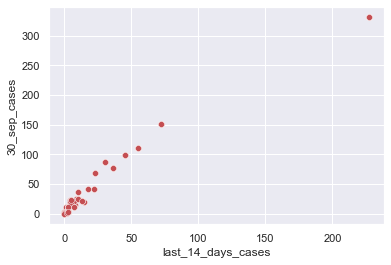

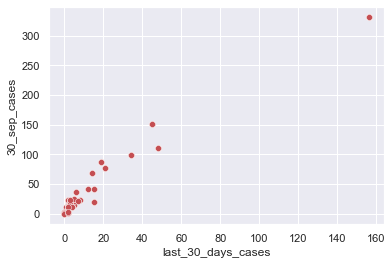

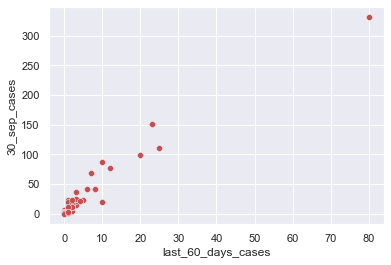

In [141]:
# plotting for original dataset without any normalization/transformation
plot_scatter(model_df, '30_sep_cases')

After plotting for the original dataset, we notice the followings:

> It disobeys our first criteria as the features are not in the same scale. As from the plot x-scales varies approx [0,214], [0-155], and [0-80], while y-axis from [-1 - 332] If we train a linear model on this dataset as it is, the model will given preference to features with higher values, which is not something we want. This concludes that we will require scaling to bring our dataset/features on the same scale.

> There is a very extreme outlier; the main points cloud is at the bottom left and appears too small though it contains approx 2000 points. We cannot see what relationship might be. Do not be mislead, if zoomed into the cloud of points, the variance may be quite high. The reason we are not able to picture it clearly is because of the outlier present. Transformations can help us achieve better results. Transformation would enable us to spread these points and may result in a better linear line fit, at the same time it may also somewhat diminish the skewness (because of the cloud and outlier) upto an extent.
**(NOTE: skewness is not the focus of task, but is an imporant factor for building linear models)**

#  2. Min-Max Normalization

The min-max normalization rescales the features to range of [0,1] but is flexible if certain range we want to choose.
Here we will take two ranges according to the transformation we choose (discussed the reasons as we go).

The concept remains the same just the ranges can be changed:

For every feature
* Minimum value of that feature gets transformed to 0
* Maximum value gets transformed to 1
* Every other value gets transformed to a decimal between 0 and 1.

The formula is as follows:

$$
x_{scaled} = \frac{x - min(x)}{max(x) - min(x)}
$$

\
**Advantage**: will bring all features to same scale

**Disadvantage**: Does not handle outliers well

In [144]:
from sklearn import preprocessing
import math

In [145]:
# creating a min_max with range [0,1]
minmax_scale_01 = preprocessing.MinMaxScaler().fit(model_df)
df_minmax_01 = minmax_scale_01.transform(model_df)
df_minmax_01[0:5]

array([[0.        , 0.        , 0.        , 0.003003  ],
       [0.        , 0.        , 0.        , 0.003003  ],
       [0.04405286, 0.03205128, 0.0375    , 0.07807808],
       [0.0660793 , 0.09615385, 0.125     , 0.06306306],
       [0.03964758, 0.03205128, 0.0375    , 0.07807808]])

In [146]:
# converting the array result to a dataframe

minmax_df_01 = pd.DataFrame(df_minmax_01, columns=model_df.columns)
minmax_df_01.head()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
0,0.000000,0.000000,0.0000,0.003003
1,0.000000,0.000000,0.0000,0.003003
2,0.044053,0.032051,0.0375,0.078078
3,0.066079,0.096154,0.1250,0.063063
4,0.039648,0.032051,0.0375,0.078078


In [147]:
# creating a min_max with range [1,2]
minmax_scale_12 = preprocessing.MinMaxScaler(feature_range=(1,2)).fit(model_df)
df_minmax_12 = minmax_scale_12.transform(model_df)
df_minmax_12[0:5]

array([[1.        , 1.        , 1.        , 1.003003  ],
       [1.        , 1.        , 1.        , 1.003003  ],
       [1.04405286, 1.03205128, 1.0375    , 1.07807808],
       [1.0660793 , 1.09615385, 1.125     , 1.06306306],
       [1.03964758, 1.03205128, 1.0375    , 1.07807808]])

In [148]:
# converting the array result to a dataframe

minmax_df_12 = pd.DataFrame(df_minmax_12, columns=model_df.columns)
minmax_df_12.head()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
0,1.000000,1.000000,1.0000,1.003003
1,1.000000,1.000000,1.0000,1.003003
2,1.044053,1.032051,1.0375,1.078078
3,1.066079,1.096154,1.1250,1.063063
4,1.039648,1.032051,1.0375,1.078078


## 2.1 Log Transformation


Formula used:

$$
Y'= log(Y)
$$

As log of 0 is undefined we cannot use the min-max scale we created for range [0,1]. This the reason we will use our min max from range [1,2] for log-transformation.

The log base can be varied and tested. Here we are using natural log.

In [149]:
model_df.describe()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
count,2392.000000,2392.000000,2392.000000,2392.000000
mean,12.166806,8.544314,4.553512,23.983696
std,34.566071,24.179668,12.519782,54.072215
min,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,1.000000,4.000000
75%,9.000000,5.000000,3.000000,22.000000
max,227.000000,156.000000,80.000000,332.000000


### 2.1.1 Log with Min Max [1,2]

In [150]:
# creaing dataframe to hold the transformed values
log_trans_minmaxdf = pd.DataFrame(columns=minmax_df_12.columns)

# applying log on each row
for name in minmax_df_12.columns:
    log_trans_minmaxdf[name] = minmax_df_12.apply(lambda row: math.log((row[name])), axis=1)


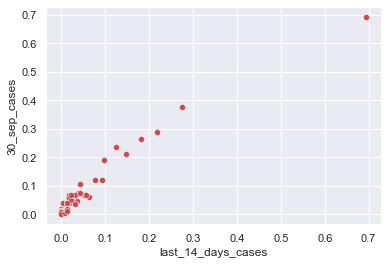

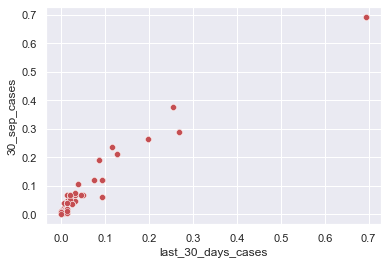

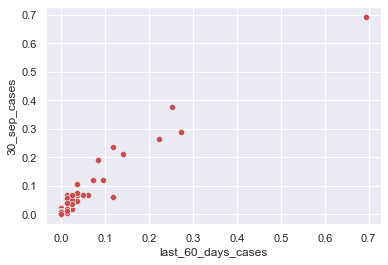

In [151]:
# plotting
plot_scatter(log_trans_minmaxdf, '30_sep_cases')

> The scale for all features have been brought to a single range, but the linearity seems very similar to the original model.

## 2.2 Power Transformation

The idea is that to transform X and Y at the same time, using some power functions.
Power can be anything we it square, cube, square root, cube root. 

Here we will be performing few as it will give us a sense of the right direction to proceed with other combinations.

Another important note is that power transformation we can perform on both ranges of min-max transformation we created. So we will explore on both the ranges.

### 2.2.1 with Min Max Transformation of Range [0,1]

In [152]:
power_trans_df_2 = pd.DataFrame(columns=minmax_df_01.columns)

for col_name in minmax_df_01.columns:
    power_trans_df_2[col_name] = minmax_df_01.apply(lambda row: math.pow( row[col_name], 2), axis=1)


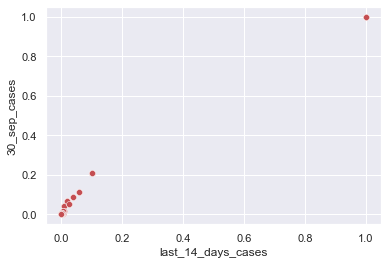

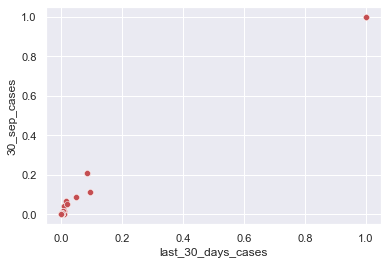

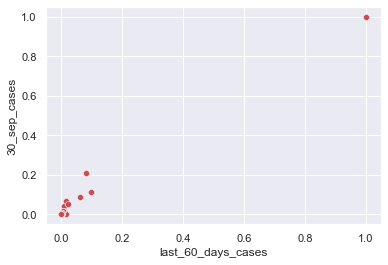

In [153]:
plot_scatter(power_trans_df_2, '30_sep_cases')

> This is not at all an improvement because of more complex cloud formation at the bottom. Hence we will not explore more higher powers like 3,4,...

Let us check powers in roots now.

In [154]:
power_trans_df_2_root = pd.DataFrame(columns=minmax_df_01.columns)

for col_name in minmax_df_01.columns:
    power_trans_df_2_root[col_name] = minmax_df_01.apply(lambda row: sqrt(row[col_name]), axis=1)



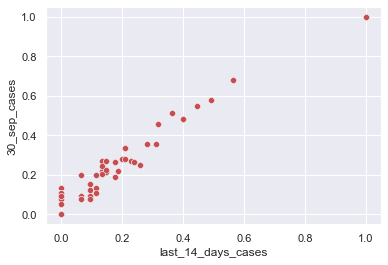

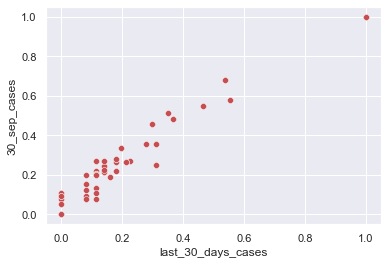

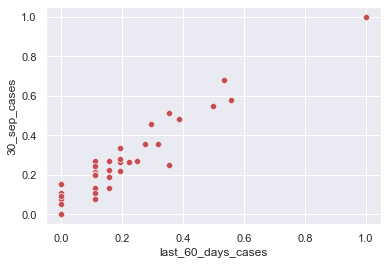

In [155]:
plot_scatter(power_trans_df_2_root, '30_sep_cases')

> This is really a good plot within the same scale and also linearity is quite steady with less spreads. Let us also try cube root too.

In [156]:
power_trans_df_3_root = pd.DataFrame(columns=minmax_df_01.columns)

for col_name in minmax_df_01.columns:
    power_trans_df_3_root[col_name] = minmax_df_01.apply(lambda row: math.pow( row[col_name], 1/3), axis=1)



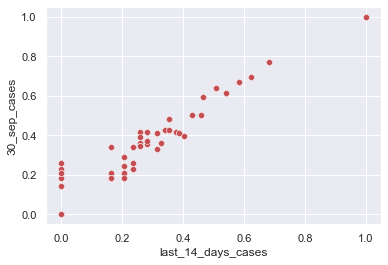

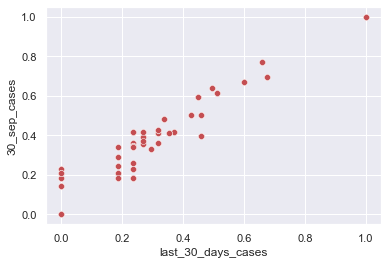

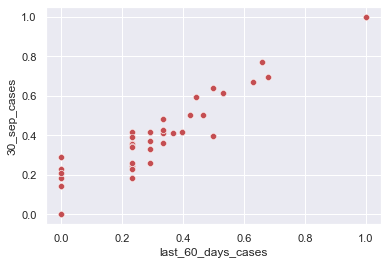

In [157]:
plot_scatter(power_trans_df_3_root, '30_sep_cases')

> This again is a good resultant plot, but we still prefer the square root as with this plot the intial points along 0 has started spreading a bit and also it is causing a discontinuity of points from approx 0.0 to 0.3.

> **Until now the best we have find is min-max in range [0,1] with power 1/2 (square root)**

### 2.2.2 with Min Max Transformation of Range [1,2]

In [158]:
# square power

power_trans_df_2 = pd.DataFrame(columns=minmax_df_12.columns)

for col_name in minmax_df_12.columns:
    power_trans_df_2[col_name] = minmax_df_12.apply(lambda row: math.pow( row[col_name], 2), axis=1)


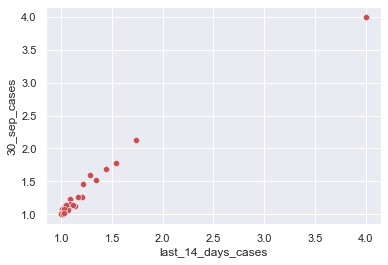

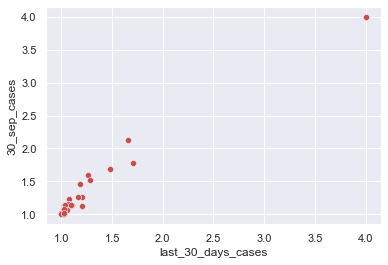

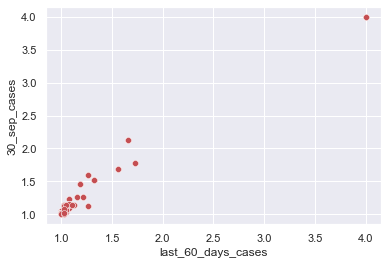

In [159]:
plot_scatter(power_trans_df_2, '30_sep_cases')

> Not better than the min-max in range [0,1] with power 1/2 (square root)

In [160]:
# power 1/2

power_trans_df_2_root = pd.DataFrame(columns=minmax_df_12.columns)

for col_name in minmax_df_12.columns:
    power_trans_df_2_root[col_name] = minmax_df_12.apply(lambda row: sqrt(row[col_name]), axis=1)



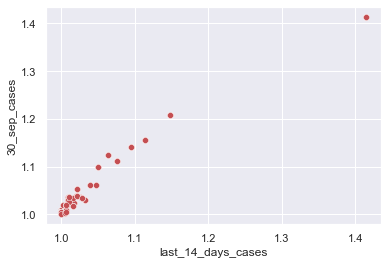

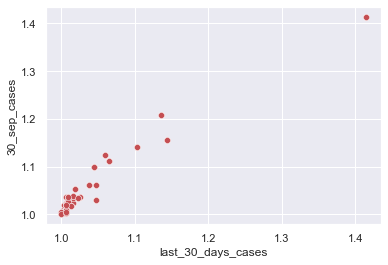

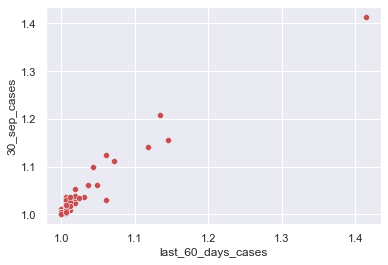

In [161]:
plot_scatter(power_trans_df_2_root, '30_sep_cases')

> Linearity is good but spread is less so again not better than the min-max in range [0,1] with power 1/2 (square root)

In [162]:
# power 1/3

power_trans_df_3_root = pd.DataFrame(columns=minmax_df_12.columns)

for col_name in minmax_df_12.columns:
    power_trans_df_3_root[col_name] = minmax_df_12.apply(lambda row: math.pow( row[col_name], 1/3), axis=1)



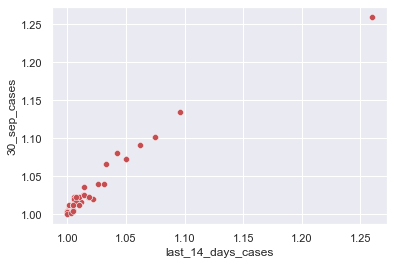

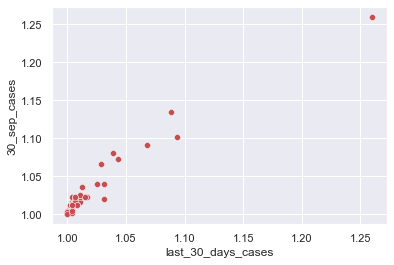

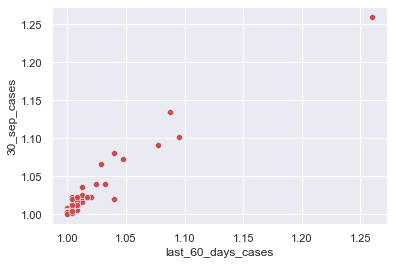

In [163]:
plot_scatter(power_trans_df_3_root, '30_sep_cases')

> Pretty similar to the previous graph, just the scale varies

## 2.3 Box-Cox Transformation

The Box-Cox transformation transforms our data so that it closely resembles a normal distribution.

At the core of the Box Cox transformation is lambda (λ), which varies from -5 to 5. The “optimal value” is the one which results in the best approximation of a normal distribution curve. 

Formula:
$$
Y'=(Y^λ -1)/λ
$$

when λ!= 0

Box-cox only works for positive data, the reason we will be using min-max of range [1,2]

In [164]:
from sklearn.preprocessing import PowerTransformer

In [165]:
pt = PowerTransformer(method='box-cox')
box_cox_transform = pt.fit_transform(minmax_df_12)
box_cox_transform

array([[-0.86002419, -0.84031788, -0.80805575, -0.92924123],
       [-0.86002419, -0.84031788, -0.80805575, -0.92924123],
       [ 0.77339331,  0.47975554,  0.58028655,  0.87012608],
       ...,
       [-0.23234404, -0.22016849, -0.24383426,  0.14485438],
       [-0.42548154, -0.22016849, -0.24383426, -0.81943402],
       [-0.23234404, -0.22016849, -0.24383426, -0.61229589]])

In [166]:
box_cox_df = pd.DataFrame(box_cox_transform, columns=minmax_df_12.columns)
box_cox_df.head()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
0,-0.860024,-0.840318,-0.808056,-0.929241
1,-0.860024,-0.840318,-0.808056,-0.929241
2,0.773393,0.479756,0.580287,0.870126
3,1.227401,1.662910,1.815140,0.631701
4,0.660368,0.479756,0.580287,0.870126


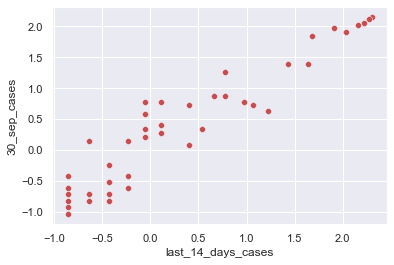

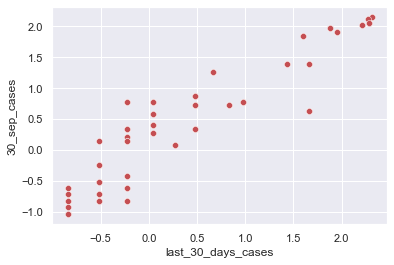

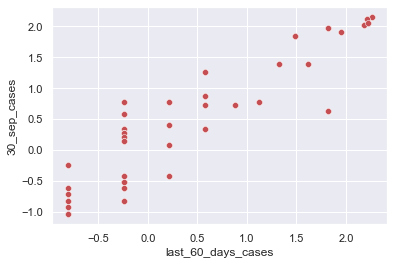

In [167]:
plot_scatter(box_cox_df, '30_sep_cases')

> These are really good graphs too, but our goal is linearity for this task. Data points are higly spread out i.e. more variations, resulting in less linear relationship

> **Side Note:** With box-cox it seems like skewness have been removed alot as compared to other transformation.

# 3. Z-Score Normalization (standardization)

The idea behind standardization is that it will transform the data such that its distribution will have a mean value 0 and standard deviation of 1. In case of multivariate data, this is done feature wise

The formula is as follows:

$$
value_{scaled} = \frac{value - μ}{σ}
$$

where,

μ : mean value of the feature

σ : standard deviation of the feature

\
With Log Transformation as log 0 is not defined we cannot implement it. Similarly box-cox required postive values but standardization also tends to transform data to negative values.

So with Standardization we can only apply **Power transformation** only from the options available to us.

In [168]:
# standardising the original data
std_scale = preprocessing.StandardScaler().fit(model_df)
df_std = std_scale.transform(model_df)
df_std[0:5]

array([[-0.35206056, -0.35344162, -0.3637814 , -0.44364209],
       [-0.35206056, -0.35344162, -0.3637814 , -0.44364209],
       [-0.06269903, -0.14661308, -0.12411051,  0.01879925],
       [ 0.08198173,  0.26704401,  0.43512157, -0.07368902],
       [-0.09163518, -0.14661308, -0.12411051,  0.01879925]])

In [169]:
# converting to dataframe
df_std_df = pd.DataFrame(df_std, columns=model_df.columns)
df_std_df.head()

,last_14_days_cases,last_30_days_cases,last_60_days_cases,30_sep_cases
0,-0.352061,-0.353442,-0.363781,-0.443642
1,-0.352061,-0.353442,-0.363781,-0.443642
2,-0.062699,-0.146613,-0.124111,0.018799
3,0.081982,0.267044,0.435122,-0.073689
4,-0.091635,-0.146613,-0.124111,0.018799


## 3.1 Power Transformation

The idea is that to transform X and Y at the same time, using some power functions. Here we only tryout square power transformation

In [170]:
power_trans_df_2 = pd.DataFrame(columns=df_std_df.columns)

for col_name in df_std_df.columns:
    power_trans_df_2[col_name] = df_std_df.apply(lambda row: math.pow( row[col_name], 2), axis=1)


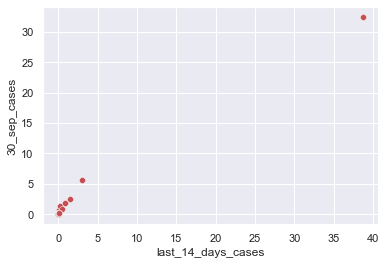

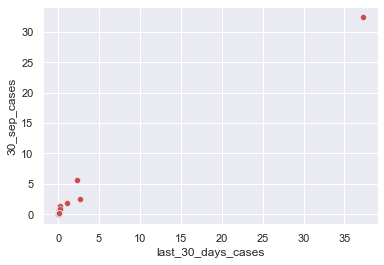

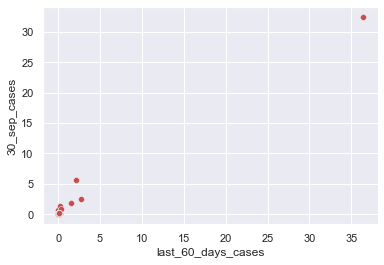

In [171]:
plot_scatter(power_trans_df_2, '30_sep_cases')

> Not at all an improvement due to dense cloud formation at the bottom and linear relationship cannot be judged.

# Conclusion

We found quite a few good normalization/transformations combinations, but the one we appears to be the best linear with same scale of fetures is

* **Min Max Transformation in Range [0,1] along with Square Root Power Transformation**

**Reason:** Good achievable linear realtionship observed with gradual spread of points in trend. Also, no dense cloud formation. Some skewness would also been decreased (but not something our focus in this task)

# References

* Machine Learning Mastery. How to Use StandardScaler and MinMaxScaler Transforms in Python. Retrieved from https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

* Statistics How to. Box Cox Transformation: Definition, Examples. Retrieved from https://www.statisticshowto.com/box-cox-transformation/

* Monash University. FIT5196 Unit Tut Week 11